In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import math
sys.path.append('../')
from Scattering_Simulator import pairwise_method

## Load the Coordinates of the Building Block
In this notebook, the scattering or a protein assembled into a tube like structure will be determined. First, the file containing the coordinates of the individual protein is loaded. 

In [51]:
coordinates = np.genfromtxt('../Data/coordinates/RhuA_367.txt', delimiter=' ', dtype=None)

Functions are defined that are used to assemble the protein into the tube like structure. 

In [52]:
def helix_coord(amp, f , low, high, n):
    y = np.linspace(low, high, n)
    x = amp*np.cos(f*y)
    z = amp*np.sin(f*y)
    return x, y, z

def meshgrid_to_array(xx):
    x_lst = []
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            for k in range(xx.shape[2]):
                x_lst.append(xx[i,j,k])
    coordinates = np.array(x_lst).reshape(-1,1)
    return coordinates 

def relative_coordinates(volume):
    # Determine the points relative to (0,0)
    rel_x = volume[:,0] - np.mean(volume[:,0])
    rel_y = volume[:,1] - np.mean(volume[:,1])
    rel_z = volume[:,2] - np.mean(volume[:,2])
    relative_volume = np.hstack((rel_x.reshape(-1,1), rel_y.reshape(-1,1), rel_z.reshape(-1,1)))
    return relative_volume

def rotation_angle(x,z,r):
    angle = -np.arctan2(z, x)*180/math.pi
    return np.round(angle)

def rotate_coordinates_y(x, z, angle):
    angle = angle*math.pi/180
    x_new = x*np.cos(angle) + z*np.sin(angle)
    z_new = -x*np.sin(angle) + z*np.cos(angle)
    return x_new, z_new

def rotate_coordinates_x(y, z, angle):
    angle = angle*math.pi/180
    y_new = y*np.cos(angle) + z*np.sin(angle)
    z_new = -y*np.sin(angle) + z*np.cos(angle)
    return y_new, z_new

def rotate_coordinates_z(x, y, angle):
    angle = angle*math.pi/180
    x_new = x*np.cos(angle) + y*np.sin(angle)
    y_new = -x*np.sin(angle) + y*np.cos(angle)
    return x_new, y_new

def rotate_coordinates(x, z, angle):
    angle = angle*math.pi/180
    x_new = x*np.cos(angle) + z*np.sin(angle)
    z_new = -x*np.sin(angle) + z*np.cos(angle)
    return x_new, z_new

def place_structure(relative_volume, x,y,z):
    x_coord = relative_volume[:,0] + x
    y_coord = relative_volume[:,1] + y
    z_coord = relative_volume[:,2] + z
    structure_coordinates = np.hstack((x_coord.reshape(-1,1), y_coord.reshape(-1,1), z_coord.reshape(-1,1)))
    return structure_coordinates

Text(0.5, 0.92, 'Protein Coordinates')

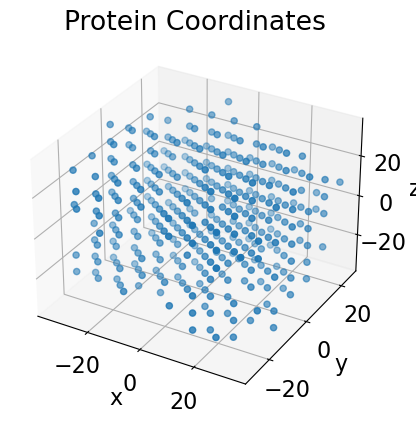

In [53]:
coordinates = relative_coordinates(coordinates)
ax = plt.axes(projection='3d')
ax.scatter(coordinates[:,0], coordinates[:,1], coordinates[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Protein Coordinates')

Text(0.5, 0.92, 'Protein Coordinates Rotated')

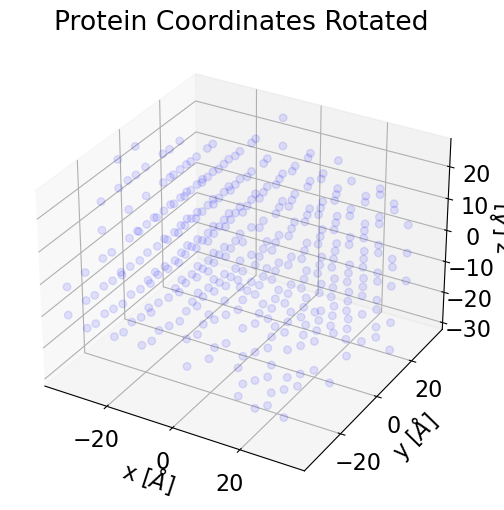

In [54]:
volume = coordinates
volume_rotated = np.hstack((volume[:,0].reshape(-1,1), volume[:,2].reshape(-1,1), volume[:,1].reshape(-1,1)))
# Plot the mean of all points
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.scatter(volume_rotated[:,0],volume_rotated[:,1],volume_rotated[:,2], color = 'blue', alpha = 0.1, s = 30)
ax.set_xlabel('x [$\AA$]')
ax.set_ylabel('y [$\AA$]')
ax.set_zlabel('z [$\AA$]')
ax.set_title('Protein Coordinates Rotated')

Text(0.5, 0.92, 'Protein Coordinates Rotated')

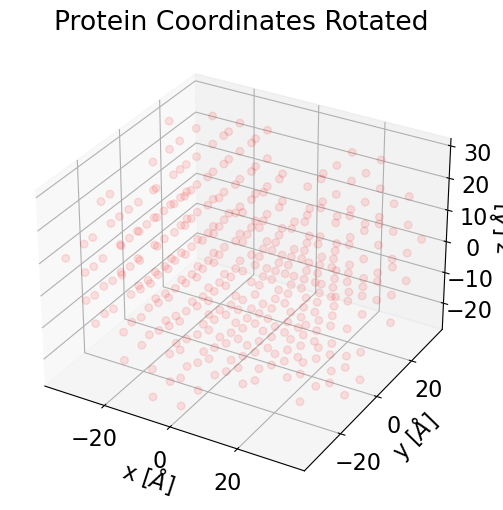

In [55]:
# Plot the mean of all points
volume_xr, volume_zr = rotate_coordinates(volume_rotated[:,0], volume_rotated[:,2], 180)
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.scatter(volume_xr, volume[:,2], volume_zr, color = 'red', alpha = 0.1, s = 30)
ax.set_xlabel('x [$\AA$]')
ax.set_ylabel('y [$\AA$]')
ax.set_zlabel('z [$\AA$]')
ax.set_title('Protein Coordinates Rotated')

The coodinates of a helix are determined using the mathematical function for a helix in 3D. A protein will be added to each coordinate with the correct rotation to create the tube

Text(0.5, 0.92, 'Helix Coordinates')

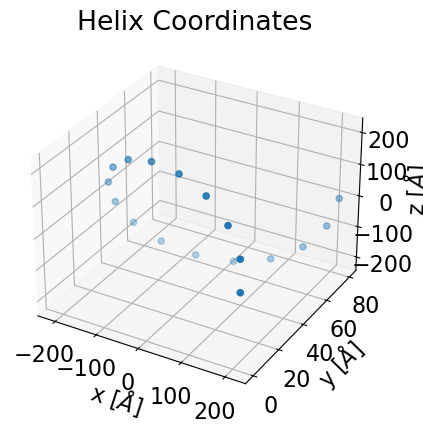

In [56]:
# Create a helix and find coordinates on it 
amp = 215 # Radius of the helix. The mean of the ID and OD of the protein tube 
start = 17

full_circles = 1 # Number of full circles (15)
low = 0
high = full_circles*80 # Length of Tube, Assuming that one circle is 80 A thick, high = full_circles*80
n = int(start*full_circles+1) # Number of Points 
f = full_circles*2*math.pi/high #frequency

x, y, z = helix_coord(amp, f, low, high, n)
plt.rcParams.update({'font.size': 16})
ax = plt.axes(projection='3d')
ax.scatter(x,y,z)
ax.set_xlabel('x [$\AA$]')
ax.set_ylabel('y [$\AA$]')
ax.set_zlabel('z [$\AA$]')
ax.set_title('Helix Coordinates')
#plt.savefig('../Figures/RhuA/Helix_Coordinates.png', dpi=300, bbox_inches="tight")

Code to add a protein on each coordinate to form a section of the tube structure

In [57]:
# Find the relative volume of the coordinates which is the coordinates centered at 0,0,0
relative_volume = relative_coordinates(volume_rotated)
# Add the relaive coordinates to coordinates on the helix 
angle_lst = []
color_lst = []
for i in range(len(x)):
    if i%2 == 0: #Alternate RhuA structure
        angle = rotation_angle(x[i], z[i], amp) + (90+180)
        color = 1
    else:
        angle = rotation_angle(x[i], z[i], amp) + 90
        color = 2
    x_list = []
    z_list = []
    angle_lst.append(angle)
    for j in range(relative_volume.shape[0]): 
        x_new, z_new = rotate_coordinates(relative_volume[j,0], relative_volume[j,2], angle)
        x_list.append(x_new)
        z_list.append(z_new)
        color_lst.append(color)
    struc_coordinates = np.hstack((np.array(x_list).reshape(-1,1), relative_volume[:,1].reshape(-1,1), np.array(z_list).reshape(-1,1)))
    struc_coordinates = place_structure(struc_coordinates, x[i], y[i], z[i])
    if i == 0:
        coordinates = struc_coordinates
    else:
        coordinates = np.vstack((coordinates, struc_coordinates,))
protein_1 = coordinates[np.where(np.array(color_lst) == 1)[0], :]
protein_2 = coordinates[np.where(np.array(color_lst) == 2)[0], :]

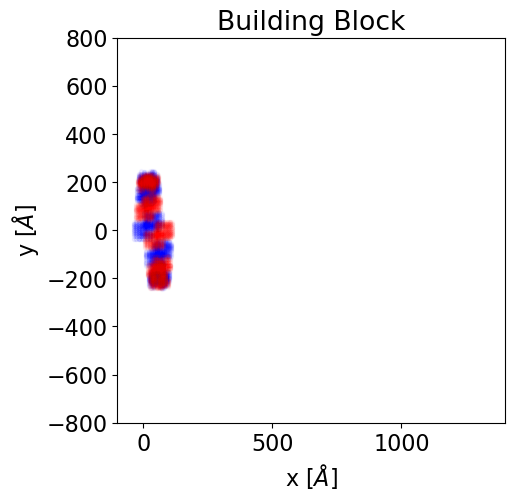

In [58]:
plt.rcParams.update({'font.size': 16})
fig = plt.subplots(figsize=(5,5))
plt.scatter(protein_1[:,1],protein_1[:,2], color = 'Blue', s = 9, alpha = 0.03)
plt.scatter(protein_2[:,1],protein_2[:,2], color = 'Red', s = 9, alpha = 0.03)
#plt.scatter([200, 400, 600, 800, 1000], [0, 0, 0, 0, 0], s = 100, color = 'k')
#plt.xlabel('Diameter of Tube, y-axis [$\AA$]')
#plt.ylabel('Diameter of Tube, z-axis [$\AA$]')
plt.xlabel('x [$\AA$]')
plt.ylabel('y [$\AA$]')
plt.xlim([-100,1400])
plt.ylim([-800,800])
plt.title('Building Block')
#plt.savefig('../Figures/RhuA/tube_side.png', dpi=300, bbox_inches="tight")
plt.show()

This structure is called "building block". The "building block" is defined as the smallest structure that can be repeated to form the larger structure. In this case, the building block will be copied in specific intervals in the z-direction to form a tube.

## Sample from the Building Block

Using the MC-DFM method, the number of "n_samples" coordinates is first sampled from the building block. 

In [59]:
n_samples = 8000000
coordinates = coordinates

In [60]:
simulator = pairwise_method.scattering_simulator(n_samples)
simulator.sample_building_block(coordinates)
#erase_coordinates
#coordinates = 0

## Sample from the Lattice

The lattice is defined as the coordinates where center of mass of the building block is copied to make the final structure. The lattice is also sampled "n_samples" times. The final tube structure has a length of 1200 Angstrom, and each protein is roughly 80 Angstrom in width. This means that there should be 15 lattice points spaced by 80 Angstrom. 

In [ ]:
lattice_points_x = 1
lattice_points_y = 15
lattice_points_z = 1
lattice_spacing_x = 0 #410
lattice_spacing_y = 80 #315
lattice_spacing_z = 0 #65
simulator.sample_lattice_function(lattice_spacing_x, lattice_spacing_y, lattice_spacing_z, lattice_points_x, lattice_points_y, lattice_points_z)

These are the coordinates of the lattice. If the center of mass of the building block is placed on each of the lattice coordinates, a tube structure will be formed. 

In [ ]:
x = np.linspace(0,0,15)
y = np.linspace(1,15*80,15)
plt.scatter(y,x)
plt.title('Lattice')

## Sample from the Structure (Building Block + Lattice)

The structure is defined as the coordinates of the building block + the lattice. This is equivalent of randomly sampling from the finished tube structure. However, by sampling the building block and the lattice *independently*, the full coordinates of the sturucture does not need to be calculated. This saves computer memory and allows the MC-DFM method to be applied to extremely large hierarchical structures.  

In [ ]:
simulator.calculate_structure_coordinates()

## Simulate the Scattering Curve

In [ ]:
histogram_bins = 7000
q = np.geomspace(0.004, 0.2, 6000)
I_q = simulator.simulate_scattering_curve(histogram_bins, q, save=True)

## Plot the Results
The results of the MC-DFM is compared to the one from Spherical Harmonics. The calculation from Spherical Harmonics is much more computationally expensive and limited by the number of coordinates it can calculate.

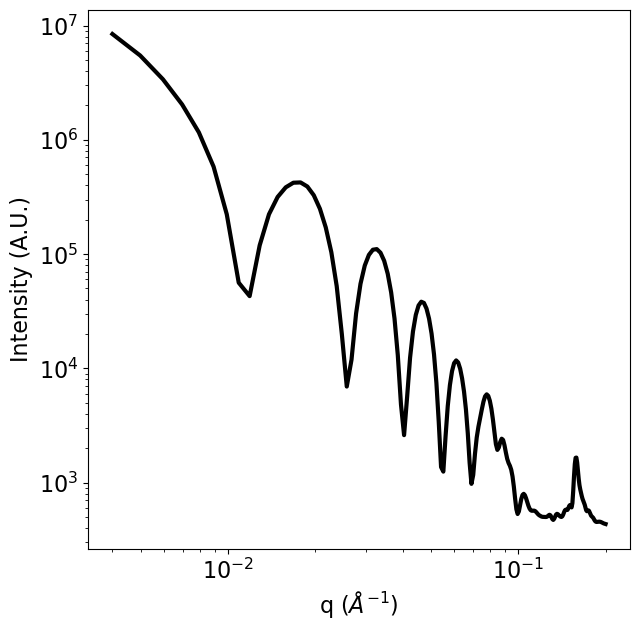

In [4]:
exp_data = np.load('../Data/scattering/SAXS_RhuA_82_Assembly_17_48OD_38ID_1200long.npy')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(7,7))

background = 4e2
plt.plot(q, I_q + background, linewidth = 3, label = 'Pairwise Method')
plt.plot(exp_data[:,0], exp_data[:,1]*3.6e-3 + background, linewidth = 3, label = 'Spherical Harmonics', color ='green')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Intensity (A.U.)')
plt.xlabel('q ($\AA^{-1}$)')
ax.minorticks_on()
plt.legend()

The randomly selected coordinates can then be plotted to confirm that the stucture that was randomly sampled matched the desired one of a tube like structure. 

In [43]:
struc = simulator.structure_coordinates_1

Text(0, 0.5, 'y axis [$\\AA$]')

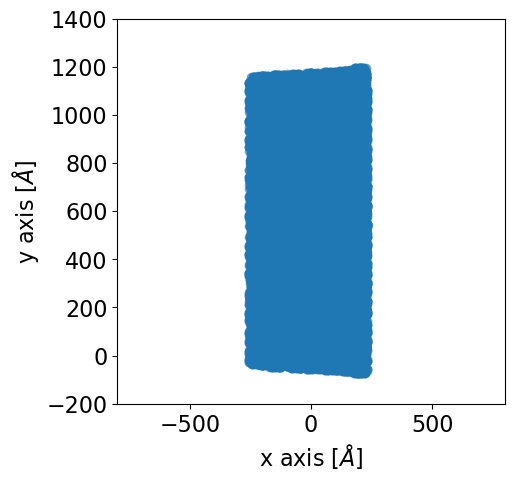

In [44]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(struc[:,0][::100], struc[:,1][::100], alpha = 0.5)
plt.xlim([-800,800])
plt.ylim([-200,1400])
#plt.axis('off')
plt.xlabel('x axis [$\AA$]')
plt.ylabel('y axis [$\AA$]')
#plt.savefig('../Figures/RhuA/Sampled_Electron_Density_Tube.jpg', dpi=300, bbox_inches="tight")

Text(0, 0.5, 'y axis [$\\AA$]')

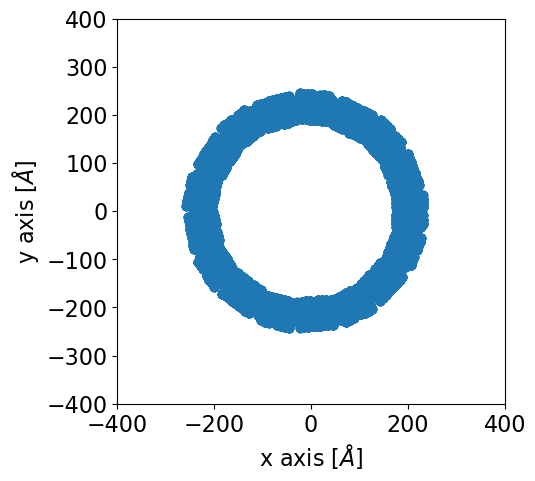

In [48]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(struc[:,0][::100], struc[:,2][::100], alpha = 0.5)
plt.xlim([-400,400])
plt.ylim([-400,400])
#plt.axis('off')
plt.xlabel('x axis [$\AA$]')
plt.ylabel('y axis [$\AA$]')
#plt.savefig('../Figures/RhuA/Sampled_Electron_Density_Tube.jpg', dpi=300, bbox_inches="tight")